

# Transfer Learning with CIFAR-10: A Two-Stage Approach

This notebook guides you through transfer learning using the CIFAR-10 dataset. The process is divided into two stages: initial training on a subset of classes and fine-tuning the model for the remaining classes



---

## Stage 1: Initial Training on a Subset of Classes

### Objective
Train a model to classify images from a subset of CIFAR-10 classes.

### Selected Classes
- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog




### Step 1: Import Necessary Libraries
Import TensorFlow, Keras, NumPy, and any other required libraries for this task. TensorFlow will be used for deep learning tasks, and NumPy will assist in numerical operatio(optinal)ns-

---


In [36]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

## Step 2: Load and Preprocess the CIFAR-10 Dataset
Load the CIFAR-10 dataset using Keras’s `keras.datasets.cifar10.load_data()` function. Normalize pixel values to the range [0, 1]. Select the 7 specified classes for the initial training, and ensure labels are converted to categorical format suitable for classification tasks.
https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

---

### 

In [21]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [22]:
x_train.shape

(50000, 32, 32, 3)

In [23]:
y_train.shape

(50000, 1)

In [25]:
stage1_classes = [0, 1, 2, 3, 4, 5, 6]
stage2_classes = [7, 8, 9]

In [26]:
# Filter Stage 1 data (first 7 classes)
stage1_train_mask = np.isin(y_train.ravel(), stage1_classes)
stage1_test_mask = np.isin(y_test.ravel(), stage1_classes)

x_train_filtered_stage1 = x_train[stage1_train_mask]
y_train_filtered_stage1 = y_train[stage1_train_mask]
x_test_filtered_stage1 = x_test[stage1_test_mask]
y_test_filtered_stage1 = y_test[stage1_test_mask]

In [27]:
# Print the shapes of the filtered dataset
print(f"x_train_filtered_stage1 shape: {x_train_filtered_stage1.shape}")
print(f"y_train_filtered_stage1 shape: {y_train_filtered_stage1.shape}")
print(f"x_test_filtered_stage1 shape: {x_test_filtered_stage1.shape}")
print(f"y_test_filtered_stage1 shape: {y_test_filtered_stage1.shape}")

x_train_filtered_stage1 shape: (35000, 32, 32, 3)
y_train_filtered_stage1 shape: (35000, 1)
x_test_filtered_stage1 shape: (7000, 32, 32, 3)
y_test_filtered_stage1 shape: (7000, 1)


**One-hot encoding**

In [28]:
# Stage 1: One-hot encode with 7 classes
y_train_filtered_stage1 = to_categorical(y_train_filtered_stage1, num_classes=len(stage1_classes))
y_test_filtered_stage1 = to_categorical(y_test_filtered_stage1, num_classes=len(stage1_classes))


**Normlization**

In [29]:
x_train_filtered_stage1 = x_train_filtered_stage1 / 255.0
x_test_filtered_stage1 = x_test_filtered_stage1 / 255.0

## Step 3: Build a   Model
Design a convolutional neural network (CNN) model. Define the architecture with convolutional layers, max-pooling layers, and fully connected layers. Experiment with different configurations and hyperparameters such as the number of layers, filters, and activation functions to achieve the best performance.

---

### 

In [30]:
from sklearn.model_selection import train_test_split

# Split the data
x_train_stage11, x_val_stage11, y_train_stage11, y_val_stage11 = train_test_split(
    x_train_filtered_stage1, y_train_filtered_stage1, test_size=0.2, random_state=42
)

In [37]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=7):
    model = Sequential([
        Conv2D(256, 3, padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),

        Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),

        Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.3),

        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

datagen = ImageDataGenerator(
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,     # Randomly shift images vertically by up to 20%
    zoom_range=0.2,             # Randomly zoom in/out on images
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Fill in missing pixels after augmentation
)

datagen.fit(x_train_filtered_stage1)

# Instantiate the model
num_classes_stage1 = 7  # Number of Stage 1 classes
model_stage1 = build_cnn_model(num_classes=num_classes_stage1)

## Step 4: Train the Model
Compile the model with an appropriate loss function, optimizer, and evaluation metrics. Fit the model using the training data and validate it using the test data. Monitor training and validation accuracy to ensure the model is learning effectively.

---



In [38]:
model_stage1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall') ,
                       tf.metrics.F1Score(name='f1-score')])

In [39]:
model_stage1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,847 (1.69 MB)

 Trainable params: 442,951 (1.69 MB)

 Non-trainable params: 896 (3.50 KB)

In [42]:
# Training the model
history_stage1 = model_stage1.fit(
    datagen.flow(x_train_stage11, y_train_stage11, batch_size=32),
    epochs=15,
    validation_data=datagen.flow(x_val_stage11, y_val_stage11, batch_size=32),
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5991 - f1-score: 0.5937 - loss: 0.3010 - precision: 0.7044 - recall: 0.4849 - val_accuracy: 0.6237 - val_f1-score: 0.6105 - val_loss: 0.2865 - val_precision: 0.7266 - val_recall: 0.5140 - learning_rate: 5.0000e-04
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6021 - f1-score: 0.5999 - loss: 0.3005 - precision: 0.7067 - recall: 0.4902 - val_accuracy: 0.6079 - val_f1-score: 0.6005 - val_loss: 0.2930 - val_precision: 0.7023 - val_recall: 0.5016 - learning_rate: 5.0000e-04
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6054 - f1-score: 0.6003 - loss: 0.2991 - precision: 0.7063 - recall: 0.4905 - val_accuracy: 0.5839 - val_f1-score: 0.5816 - val_loss: 0.3046 - val_precision: 0.6866 - val_recall: 0.4854 - learning_rate: 5.0000e-04
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5995 - f1-score: 0.5966 - loss: 0.3023 - precision: 0.7082 - recall: 0.4879 - val_accu

In [43]:
# Evaluate the model
metrics = model_stage1.evaluate(x_test_filtered_stage1, y_test_filtered_stage1, verbose=1)

# Access the metrics by index
loss = metrics[0]
accuracy = metrics[1]
precision = metrics[2]
recall = metrics[3]
f1_score = metrics[4]

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score : {np.mean(f1_score):.4f}") # Print the average F1 score

# Make predictions
predictions = model_stage1.predict(x_test_filtered_stage1)

# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7309 - f1-score: 0.7216 - loss: 0.2152 - precision: 0.7779 - recall: 0.6793
Test Loss: 0.2156
Test Accuracy: 0.7310
Test Precision: 0.7756
Test Recall: 0.6806
Test F1 Score : 0.7217
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


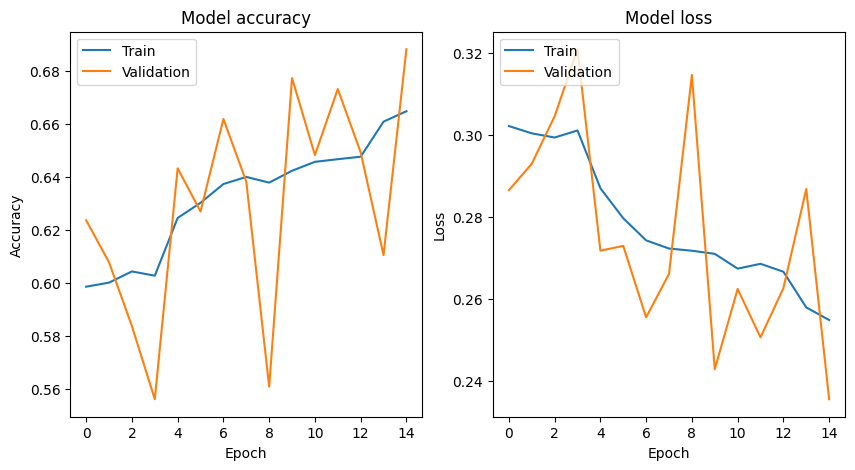

In [44]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'])
plt.plot(history_stage1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'])
plt.plot(history_stage1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
# Make predictions for all test data
predictions = model_stage1.predict(x_test_filtered_stage1)  # Predict on all x_test_filtered_stage1
predicted_classes = np.argmax(predictions, axis=1)  # Get predicted classes for all predictions


confusion = tf.math.confusion_matrix(labels=np.argmax(y_test_filtered_stage1, axis=1), predictions=predicted_classes, num_classes=num_classes_stage1)

confusion

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[888,  51,  25,   5,  16,   1,  14],
       [  4, 984,   0,   0,   2,   2,   8],
       [100,  17, 518,  21,  93,  45, 206],
       [ 42,  40,  55, 431,  63, 123, 246],
       [ 31,   4,  43,  15, 704,  14, 189],
       [ 22,  17,  34, 105,  76, 653,  93],
       [  7,  11,  15,  12,  10,   6, 939]], dtype=int32)>

**confusion matrix**

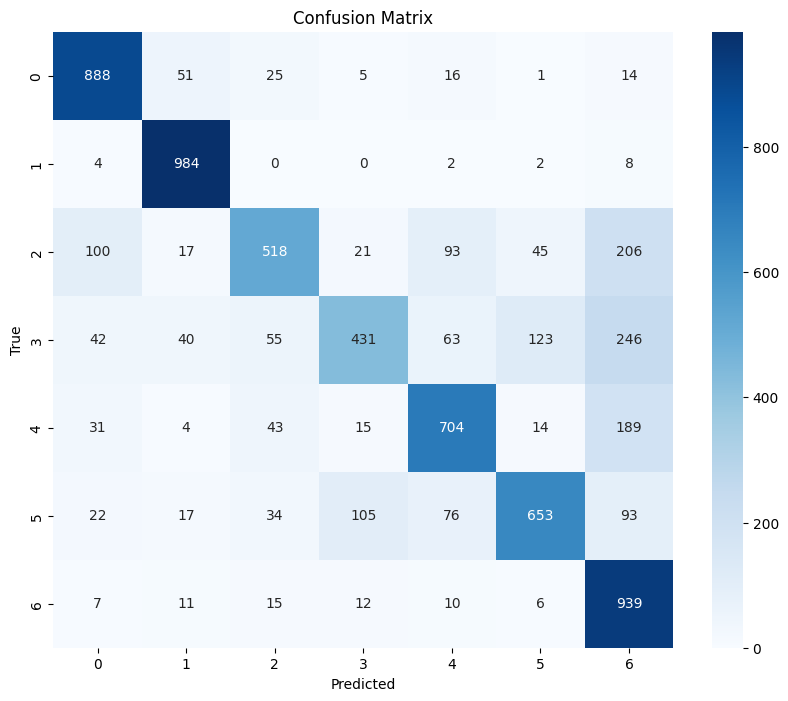

In [46]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes_stage1), yticklabels=range(num_classes_stage1))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Step 5: Save the Model and Weights
Once training is complete, save the model using the right function. This ensures you can reuse the model in the next stage without retraining.

---


In [48]:
model_stage1.save('model_stage1_final.h5')


## Stage 2: Fine-Tuning for the Remaining Classes

### Objective
Adapt the pre-trained model to classify images from the remaining CIFAR-10 classes.

### Remaining Classes
- Horse
- Ship
- Truck



---

### Step 1: Load the Pre-Trained Model
Load the saved model from Stage 1 using Keras’s `keras.models.load_model()` function, or any other function.

---

In [50]:
# Load the model
model_stage1 = load_model('/kaggle/working/model_stage1_final.h5')

# Verify the model structure
model_stage1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,849 (1.69 MB)

 Trainable params: 442,951 (1.69 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 2 (12.00 B)



### Step 2: Freeze Layers of the Pre-Trained Model
Freeze the layers of the pre-trained model to retain the features learned during Stage 1. Only unfreeze the last few layers or add new layers for fine-tuning to adapt the model to the new classification task.

---


In [51]:
# Freeze all layers in the pre-trained model
for layer in model_stage1.layers:
    layer.trainable = False


### Step 3: Replace the Output Layer
Replace the output layer of the pre-trained model with a new one that has the appropriate number of units (3 in this case) for the remaining classes. Use a softmax activation function to output probabilities for each class.

---


In [52]:
model_stage2 = Sequential()
for layer in model_stage1.layers[:-1]:  # Exclude the last layer (output layer) of model_stage1
    model_stage2.add(layer)
model_stage2.add(Flatten())
model_stage2.add(Dense(256, activation='relu'))
model_stage2.add(Dense(3, activation='softmax')) # Output layer for 3 classes


### Step 4: Prepare Data for the Remaining Classes
Extract the data corresponding to the remaining classes (Horse, Ship, and Truck) from the CIFAR-10 dataset. Preprocess the data similarly to Stage 1 and ensure the labels are converted to categorical format.

---


In [53]:
# Filter Stage 2 data (last 3 classes)
stage2_train_mask = np.isin(y_train.ravel(), stage2_classes)
stage2_test_mask = np.isin(y_test.ravel(), stage2_classes)

x_train_filtered_stage2 = x_train[stage2_train_mask]
y_train_filtered_stage2 = y_train[stage2_train_mask]
x_test_filtered_stage2 = x_test[stage2_test_mask]
y_test_filtered_stage2= y_test[stage2_test_mask]

In [54]:
# Print the shapes of the filtered datasets
print(f"x_train_filtered_stage2 shape: {x_train_filtered_stage2.shape}")
print(f"y_train_filtered_stage2 shape: {y_train_filtered_stage2.shape}")
print(f"x_test_filtered_stage2 shape: {x_test_filtered_stage2.shape}")
print(f"y_test_filtered_stage2 shape: {y_test_filtered_stage2.shape}")

x_train_filtered_stage2 shape: (15000, 32, 32, 3)
y_train_filtered_stage2 shape: (15000, 1)
x_test_filtered_stage2 shape: (3000, 32, 32, 3)
y_test_filtered_stage2 shape: (3000, 1)


**One-hot encoding**

In [55]:
y_train_filtered_stage2 = y_train_filtered_stage2 - 7
y_test_filtered_stage2 = y_test_filtered_stage2 - 7


#  Stage 2: One-hot encode with 3 classes
y_train_filtered_stage2 = to_categorical(y_train_filtered_stage2, num_classes=3)
y_test_filtered_stage2 = to_categorical(y_test_filtered_stage2, num_classes=3)

**Normlization**

In [56]:
x_train_filtered_stage2 = x_train_filtered_stage2 / 255.0
x_test_filtered_stage2 = x_test_filtered_stage2 / 255.0


### Step 5: Fine-Tune the Model
Compile the model with an appropriate loss function, optimizer, and evaluation metrics. Train the model using the data for the remaining classes, ensuring that the previously learned features are preserved while optimizing for the new task.

---


In [57]:
# Compile the model
model_stage2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall') ,
                       tf.metrics.F1Score(name='f1-score')])

In [59]:
history_stage2 = model_stage2.fit(
    x_train_filtered_stage2, y_train_filtered_stage2,
    epochs=15,                     
    batch_size=32,                  
    validation_split=0.2, 
    verbose=1                       
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7446 - f1-score: 0.7439 - loss: 0.5936 - precision: 0.7852 - recall: 0.6863 - val_accuracy: 0.8323 - val_f1-score: 0.8325 - val_loss: 0.4134 - val_precision: 0.8570 - val_recall: 0.7973
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7867 - f1-score: 0.7860 - loss: 0.5233 - precision: 0.8185 - recall: 0.7484 - val_accuracy: 0.8323 - val_f1-score: 0.8328 - val_loss: 0.4167 - val_precision: 0.8545 - val_recall: 0.7970
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7964 - f1-score: 0.7966 - loss: 0.5039 - precision: 0.8225 - recall: 0.7648 - val_accuracy: 0.8133 - val_f1-score: 0.8131 - val_loss: 0.4467 - val_precision: 0.8387 - val_recall: 0.7767
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7944 - f1-score: 0.7929 - loss: 0.5093 - precision: 0.8222 - recall: 0.7544 - val_accuracy: 0.8290 - val_f1-score: 0.8288 - val_loss: 0.4282 - val_precision: 0.8624 - val_recall:

In [60]:
# Evaluate the model
metrics = model_stage2.evaluate(x_test_filtered_stage2, y_test_filtered_stage2, verbose=1)

# Access the metrics by index
loss = metrics[0]
accuracy = metrics[1]
precision = metrics[2]
recall = metrics[3]
f1_score = metrics[4]

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score : {np.mean(f1_score):.4f}") # Print the average F1 score

# Make predictions
predictions = model_stage1.predict(x_test_filtered_stage2)

# Get predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8323 - f1-score: 0.8320 - loss: 0.4462 - precision: 0.8609 - recall: 0.7880
Test Loss: 0.4334
Test Accuracy: 0.8383
Test Precision: 0.8688
Test Recall: 0.7943
Test F1 Score : 0.8374
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


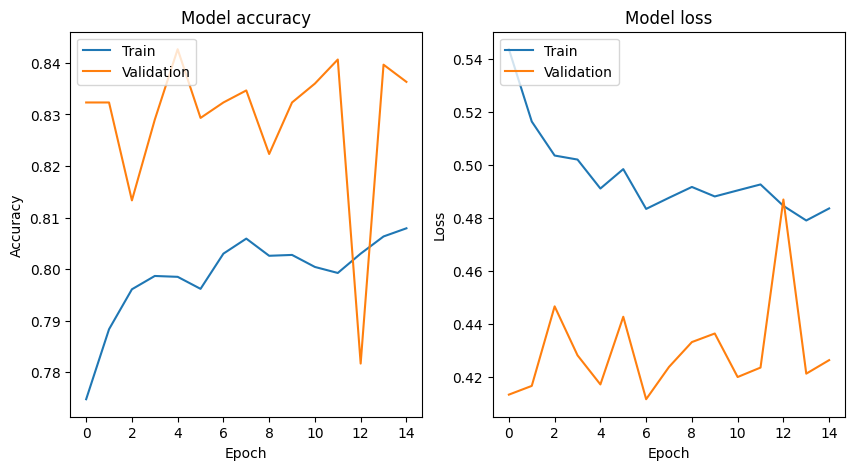

In [61]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_stage2.history['accuracy'])
plt.plot(history_stage2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_stage2.history['loss'])
plt.plot(history_stage2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**confusion matrix**

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


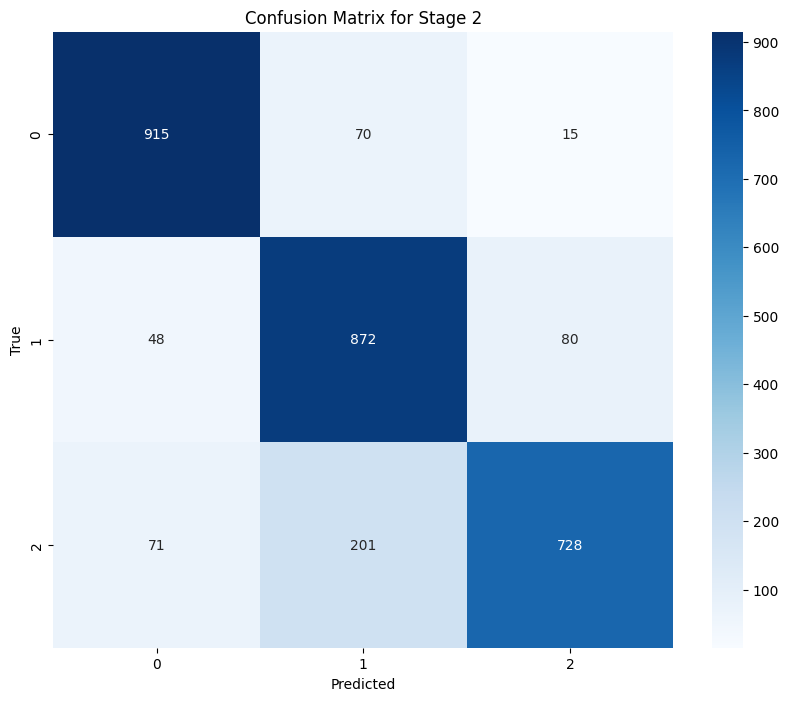

In [62]:
num_classes_stage2 = 3

# Make predictions for stage 2 using the correct model
predictions_stage2 = model_stage2.predict(x_test_filtered_stage2)
predicted_classes_stage2 = np.argmax(predictions_stage2, axis=1)

confusion_stage2 = tf.math.confusion_matrix(labels=np.argmax(y_test_filtered_stage2, axis=1), predictions=predicted_classes_stage2, num_classes=num_classes_stage2)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_stage2, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes_stage2), yticklabels=range(num_classes_stage2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Stage 2')
plt.show()


### Conclusion
Compare performance between Stage 1 and Stage 2:

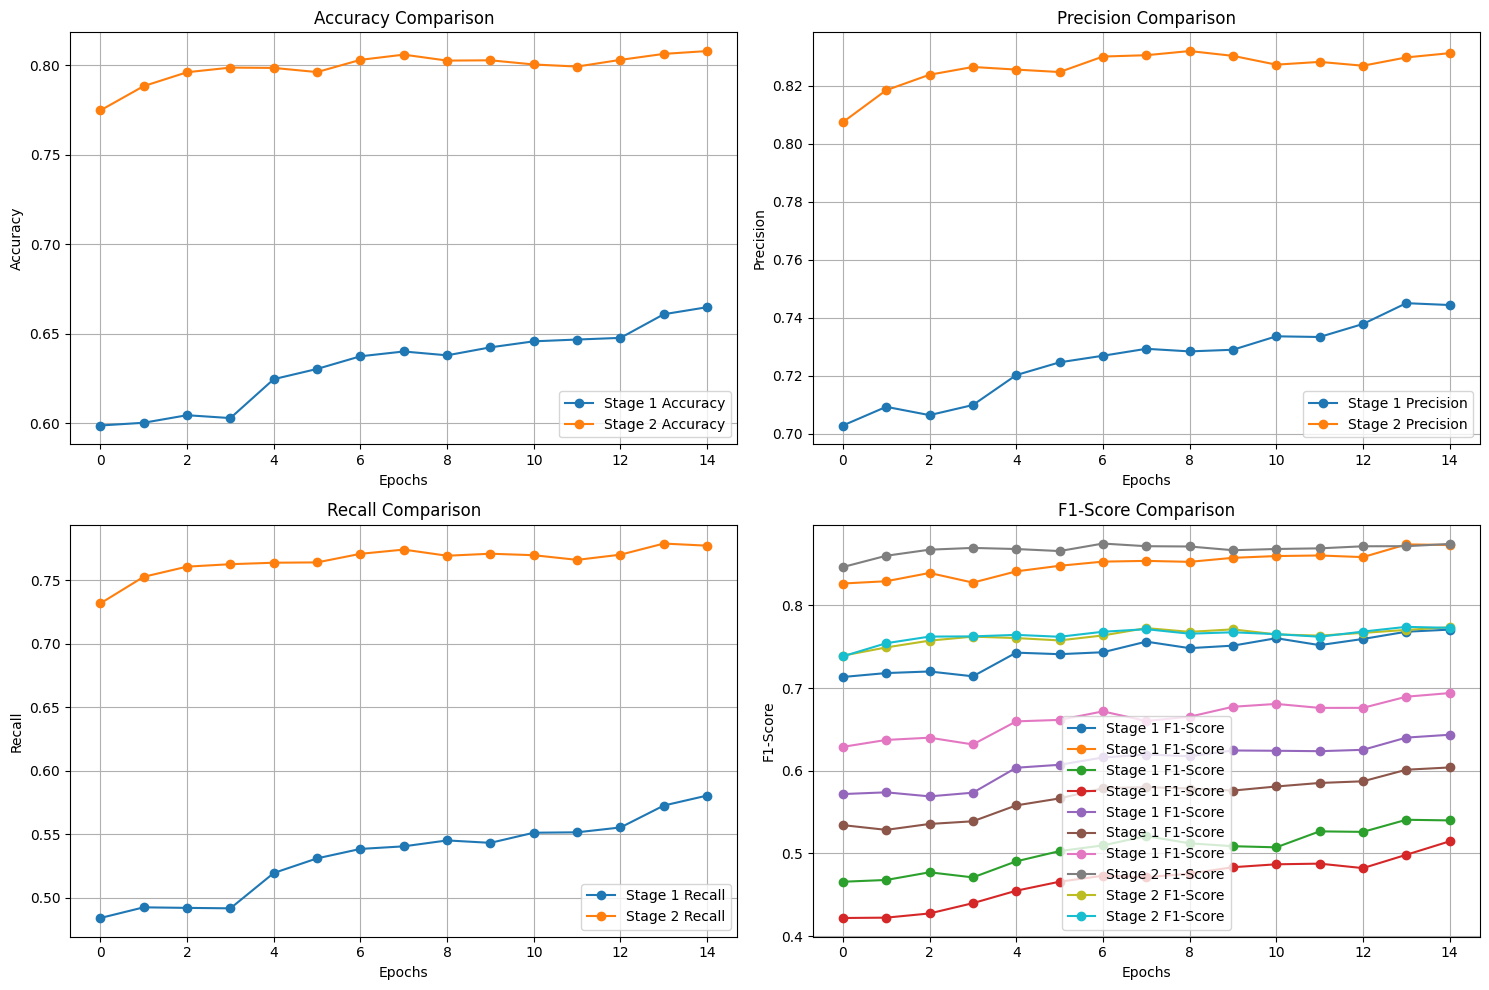

In [63]:
# Stage 1 metrics
stage1_accuracy = history_stage1.history['accuracy']
stage1_precision = history_stage1.history['precision']
stage1_recall = history_stage1.history['recall']
stage1_f1_score = history_stage1.history['f1-score']

# Stage 2 metrics
stage2_accuracy = history_stage2.history['accuracy']
stage2_precision = history_stage2.history['precision']
stage2_recall = history_stage2.history['recall']
stage2_f1_score = history_stage2.history['f1-score']

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Accuracy
axs[0, 0].plot( stage1_accuracy, label='Stage 1 Accuracy', marker='o')
axs[0, 0].plot( stage2_accuracy, label='Stage 2 Accuracy', marker='o')
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid()

# Plot Precision
axs[0, 1].plot( stage1_precision, label='Stage 1 Precision', marker='o')
axs[0, 1].plot( stage2_precision, label='Stage 2 Precision', marker='o')
axs[0, 1].set_title('Precision Comparison')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].legend()
axs[0, 1].grid()

# Plot Recall
axs[1, 0].plot( stage1_recall, label='Stage 1 Recall', marker='o')
axs[1, 0].plot(stage2_recall, label='Stage 2 Recall', marker='o')
axs[1, 0].set_title('Recall Comparison')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()
axs[1, 0].grid()

# Plot F1-Score
axs[1, 1].plot( stage1_f1_score, label='Stage 1 F1-Score', marker='o')
axs[1, 1].plot( stage2_f1_score, label='Stage 2 F1-Score', marker='o')
axs[1, 1].set_title('F1-Score Comparison')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('F1-Score')
axs[1, 1].legend()
axs[1, 1].grid()

# Adjust layout
plt.tight_layout()
plt.show()